# Determine the best features using a Logistic Regression Model

## Imports

In [ ]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from joblib import dump, load

sys.path.append("../../utils")
import analysis_utils as au
import preprocess_utils as ppu
import eval_utils as eu
import train_utils as tu

# Seed and Generator for Reproducibility

In [ ]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

In [ ]:
out_path = Path("tuned_model_feature_importance_figures")

if not out_path.exists():
    out_path.mkdir()

## Load Model

In [ ]:
models_path = Path(
    "../../1.train_models/trained_models_feature_selection/plate3_cp_fs_data"
)

lr = load(models_path / "lr_model.joblib")

## Save Data

In [ ]:
testdf = load(models_path / "testdf_tuned.joblib")
le = load(models_path / "label_encoder_tuned.joblib")

## Make Predictions

In [ ]:
testdf["preds"] = lr.predict(testdf.drop("label", axis="columns"))

In [1]:
print(f"Accuracy = {accuracy_score(testdf['label'], testdf['preds'])}")

Accuracy = 0.8891138101664418


## Create Dataframe with coefficients for each Genotype

In [ ]:
featdf = testdf.drop(testdf.index)
featdf.drop(["label", "preds"], inplace=True, axis=1)
featdf = featdf.T
featdf = featdf.reset_index()
featdf = featdf.rename(columns={"index": "features"})

In [ ]:
featdf = pd.concat(
    [pd.DataFrame(lr.coef_.T, columns=le.classes_.tolist()), featdf], axis="columns"
)
featdf["abs_HET"] = featdf["HET"].abs()

## Find Confusion Matrix

Installed tk event loop hook.


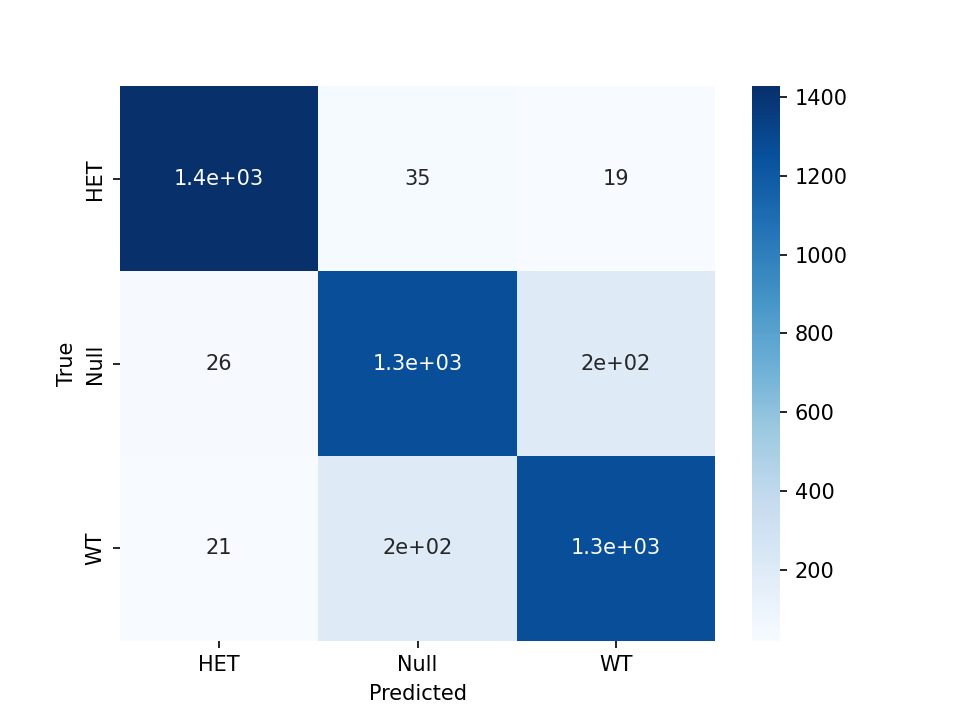

In [2]:
plt.clf()

cm3 = pd.crosstab(
    testdf["label"], testdf["preds"], rownames=["True"], colnames=["Predicted"]
)
sns.heatmap(
    cm3,
    annot=True,
    cmap="Blues",
    xticklabels=le.classes_.tolist(),
    yticklabels=le.classes_.tolist(),
)
plt.savefig(f"{out_path}/lr_conf_mat.png")

In [3]:
### Find the number of incorrect predicted examples for each predicted label
(cm3.sum() - np.diag(cm3)).sort_values(ascending=False)

Predicted
1    232
2    214
0     47
dtype: int64

## Create dictionaries that map labels

In [ ]:
pos_genes = ["HET", "Null", "WT"]
label2gene = dict(zip(le.transform(pos_genes), pos_genes))
gene2label = {gene: label for label, gene in label2gene.items()}

## Create a DataFrame with all correctly predicted data

In [ ]:
correct_filt = (
    ((testdf["preds"] == 0) & (testdf["label"] == 0))
    | ((testdf["preds"] == 1) & (testdf["label"] == 1))
    | ((testdf["preds"] == 2) & (testdf["label"] == 2))
)
correctdf = testdf.loc[correct_filt]
correctdf = correctdf.reset_index(drop=True)
# featdf['Null'].values * null_wt_wrongdf.drop(['label','preds'], axis=1).values

## Find the most important features by average

In [ ]:
featimp = {}
kept_cols = correctdf.drop(
    ["label", "preds"], axis="columns"
).columns  # Columns to be used as features

for genotype in featdf[pos_genes]:
    featimp[genotype] = {}  # Create a DataFrame for each genotype
    label = gene2label[genotype]  # Get the label for the genotype
    gene_filt = correctdf["label"] == label  # Filter to get the data for a genotype
    mat_imp = (
        featdf[genotype].values
        * correctdf.loc[gene_filt].drop(["label", "preds"], axis="columns").values
    )  # Product of model weights by the feature values
    featimp[genotype]["featdf"] = pd.DataFrame(
        mat_imp, columns=kept_cols.to_list()
    )  # Create the dataframe of product of model weights by the feature values
    row_sums = featimp[genotype]["featdf"].apply(
        lambda row: row[row > 0].sum(), axis=1
    )  # Find the sum for each row
    featimp[genotype]["featnorm"] = featimp[genotype]["featdf"].div(
        row_sums, axis=0
    )  # Find the relative product importances for each feature

    # Calculate quartiles and IQR:
    q1 = featimp[genotype]["featnorm"].quantile(0.25)
    q3 = featimp[genotype]["featnorm"].quantile(0.75)
    iqr = q3 - q1
    # Calculate bounds:
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Remove outliers:
    featimp[genotype]["featnorm"] = featimp[genotype]["featnorm"][
        (featimp[genotype]["featnorm"] >= lower_bound)
        & (featimp[genotype]["featnorm"] <= upper_bound)
    ]

    featimp[genotype]["featnorm_avg"] = featimp[genotype]["featnorm"][
        featimp[genotype]["featnorm"] > 0
    ].mean()  # Calculate the mean of samples that contributed to the correct prediction
    featimp[genotype]["featnorm_avg"].dropna(inplace=True)
    min_val = featimp[genotype]["featnorm_avg"].min()
    max_val = featimp[genotype]["featnorm_avg"].max()
    featimp[genotype]["featnorm_avg_norm"] = (
        featimp[genotype]["featnorm_avg"] - min_val
    ) / (
        max_val - min_val
    )  # Normalize averaged features, since feature importance is hierarchical

    featimp[genotype]["featnorm_avg_norm"] = featimp[genotype][
        "featnorm_avg_norm"
    ].sort_values(
        ascending=False
    )  # Sort noramalized, averaged features
    featimp[genotype]["featnorm_avg"] = featimp[genotype]["featnorm_avg"].sort_values(
        ascending=False
    )  # Sort averaged features

## Find Common Columns and average the averaged feature imporatances accross genotype

In [ ]:
totfeatimp = {}
common_indices = (
    featimp["HET"]["featnorm_avg"]
    .index.intersection(featimp["Null"]["featnorm_avg"].index)
    .intersection(featimp["WT"]["featnorm_avg"].index)
)
for idx in common_indices:
    totfeatimp[idx] = (
        featimp["HET"]["featnorm_avg"][idx]
        + featimp["Null"]["featnorm_avg"][idx]
        + featimp["WT"]["featnorm_avg"][idx]
    ) / 3

## Convert Importances to sorted normalized series

In [ ]:
totfeatimp = pd.Series(totfeatimp)

min_val = totfeatimp.min()
max_val = totfeatimp.max()
totfeatimp = (totfeatimp - min_val) / (
    max_val - min_val
)  # Normalize averaged features, since feature importance is hierarchical

totfeatimp = totfeatimp.sort_values(ascending=False)

## Create an output path for figures

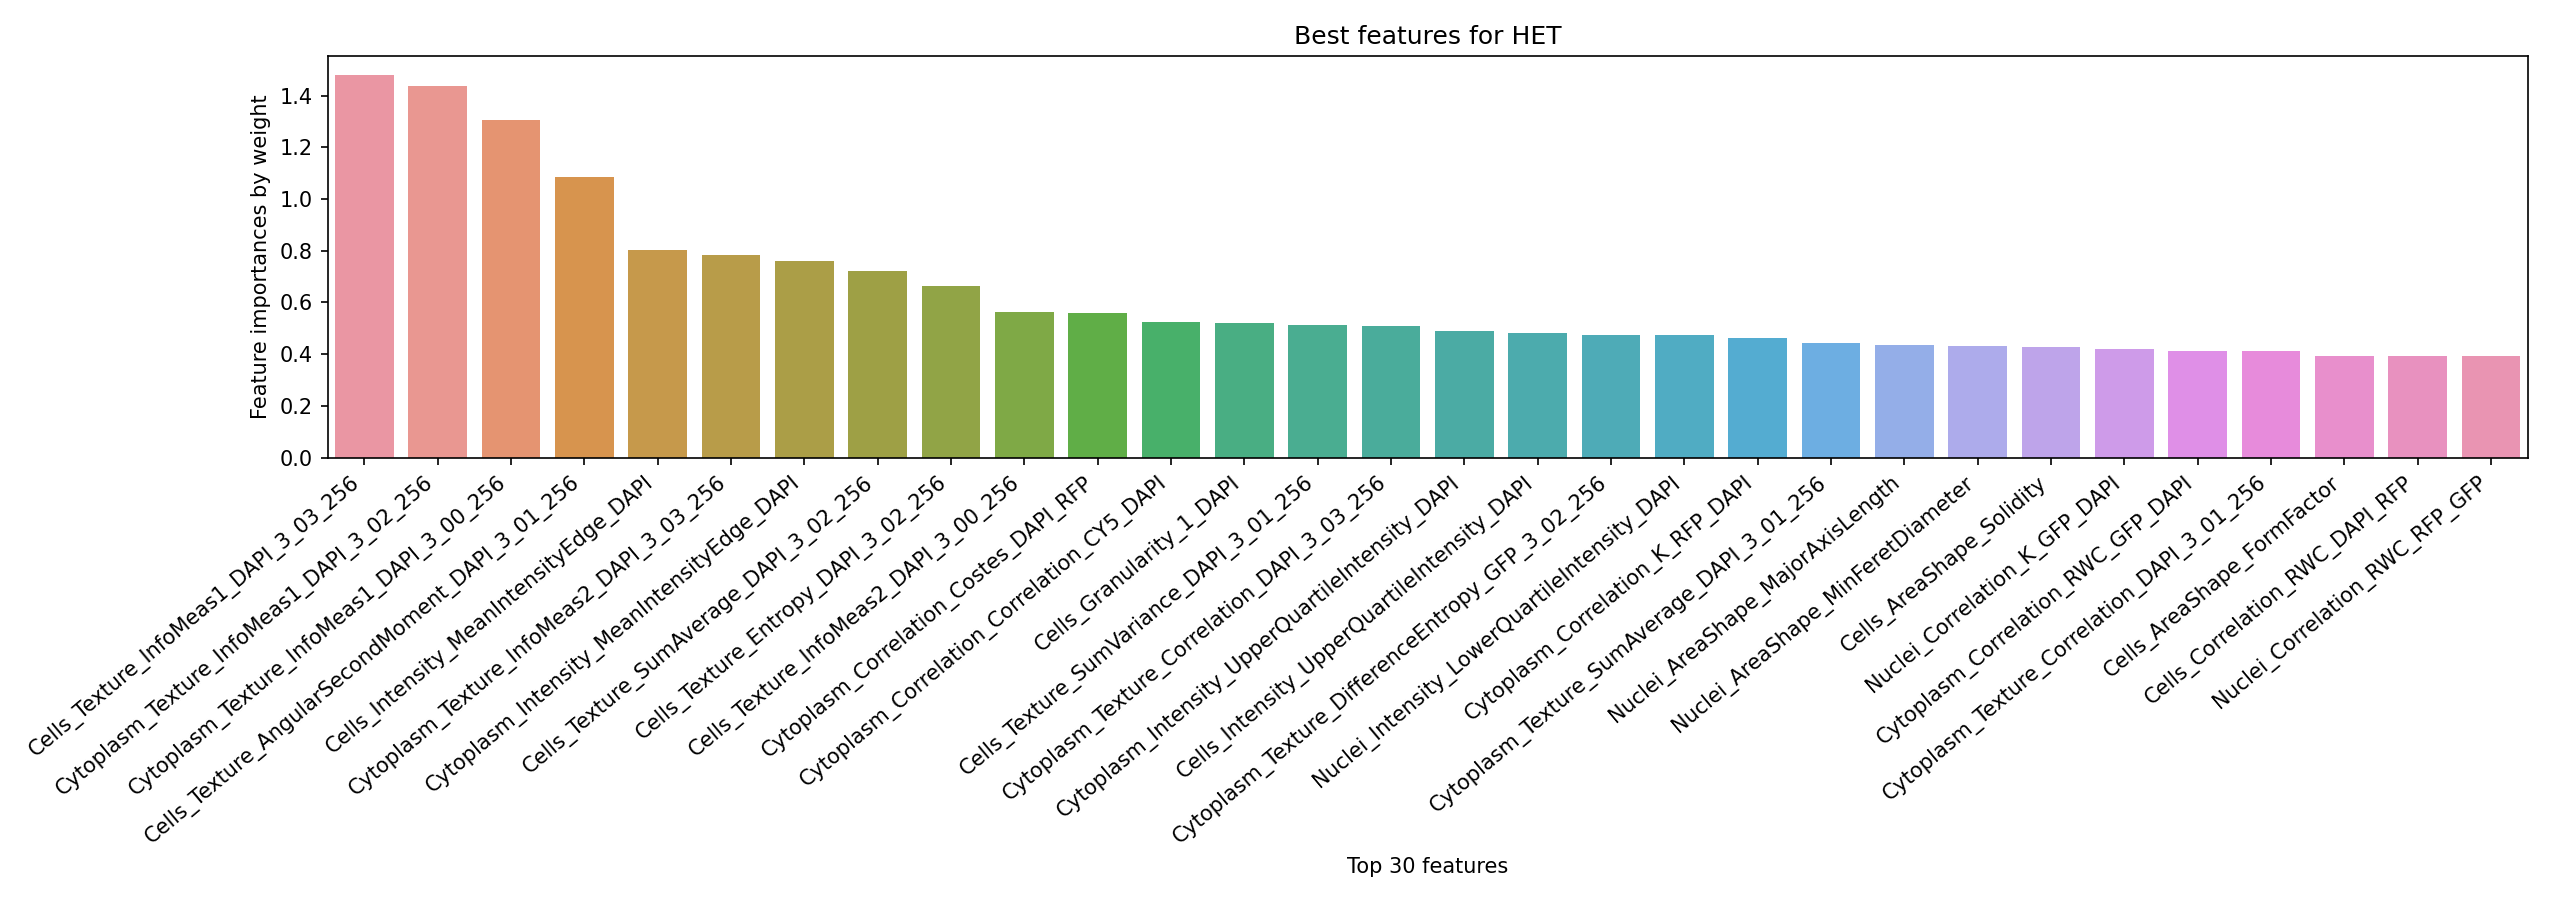

In [4]:
featdf = featdf.sort_values("abs_HET", ascending=False)

disp_feat = 30
gtype = "HET"

feat_imp = featdf["abs_HET"][:disp_feat]
col_names = featdf["features"][:disp_feat]
plt.figure(figsize=(17, 6))
ax = sns.barplot(x=np.arange(disp_feat), y=feat_imp)
ax.set_xticklabels(col_names, rotation=40, ha="right")
plt.ylabel("Feature importances by weight")
plt.xlabel(f"Top {disp_feat} features")
plt.title(f"Best features for {gtype}")
plt.tight_layout()
plt.savefig(f"{out_path}/{gtype}_feature_importances_by_weight")

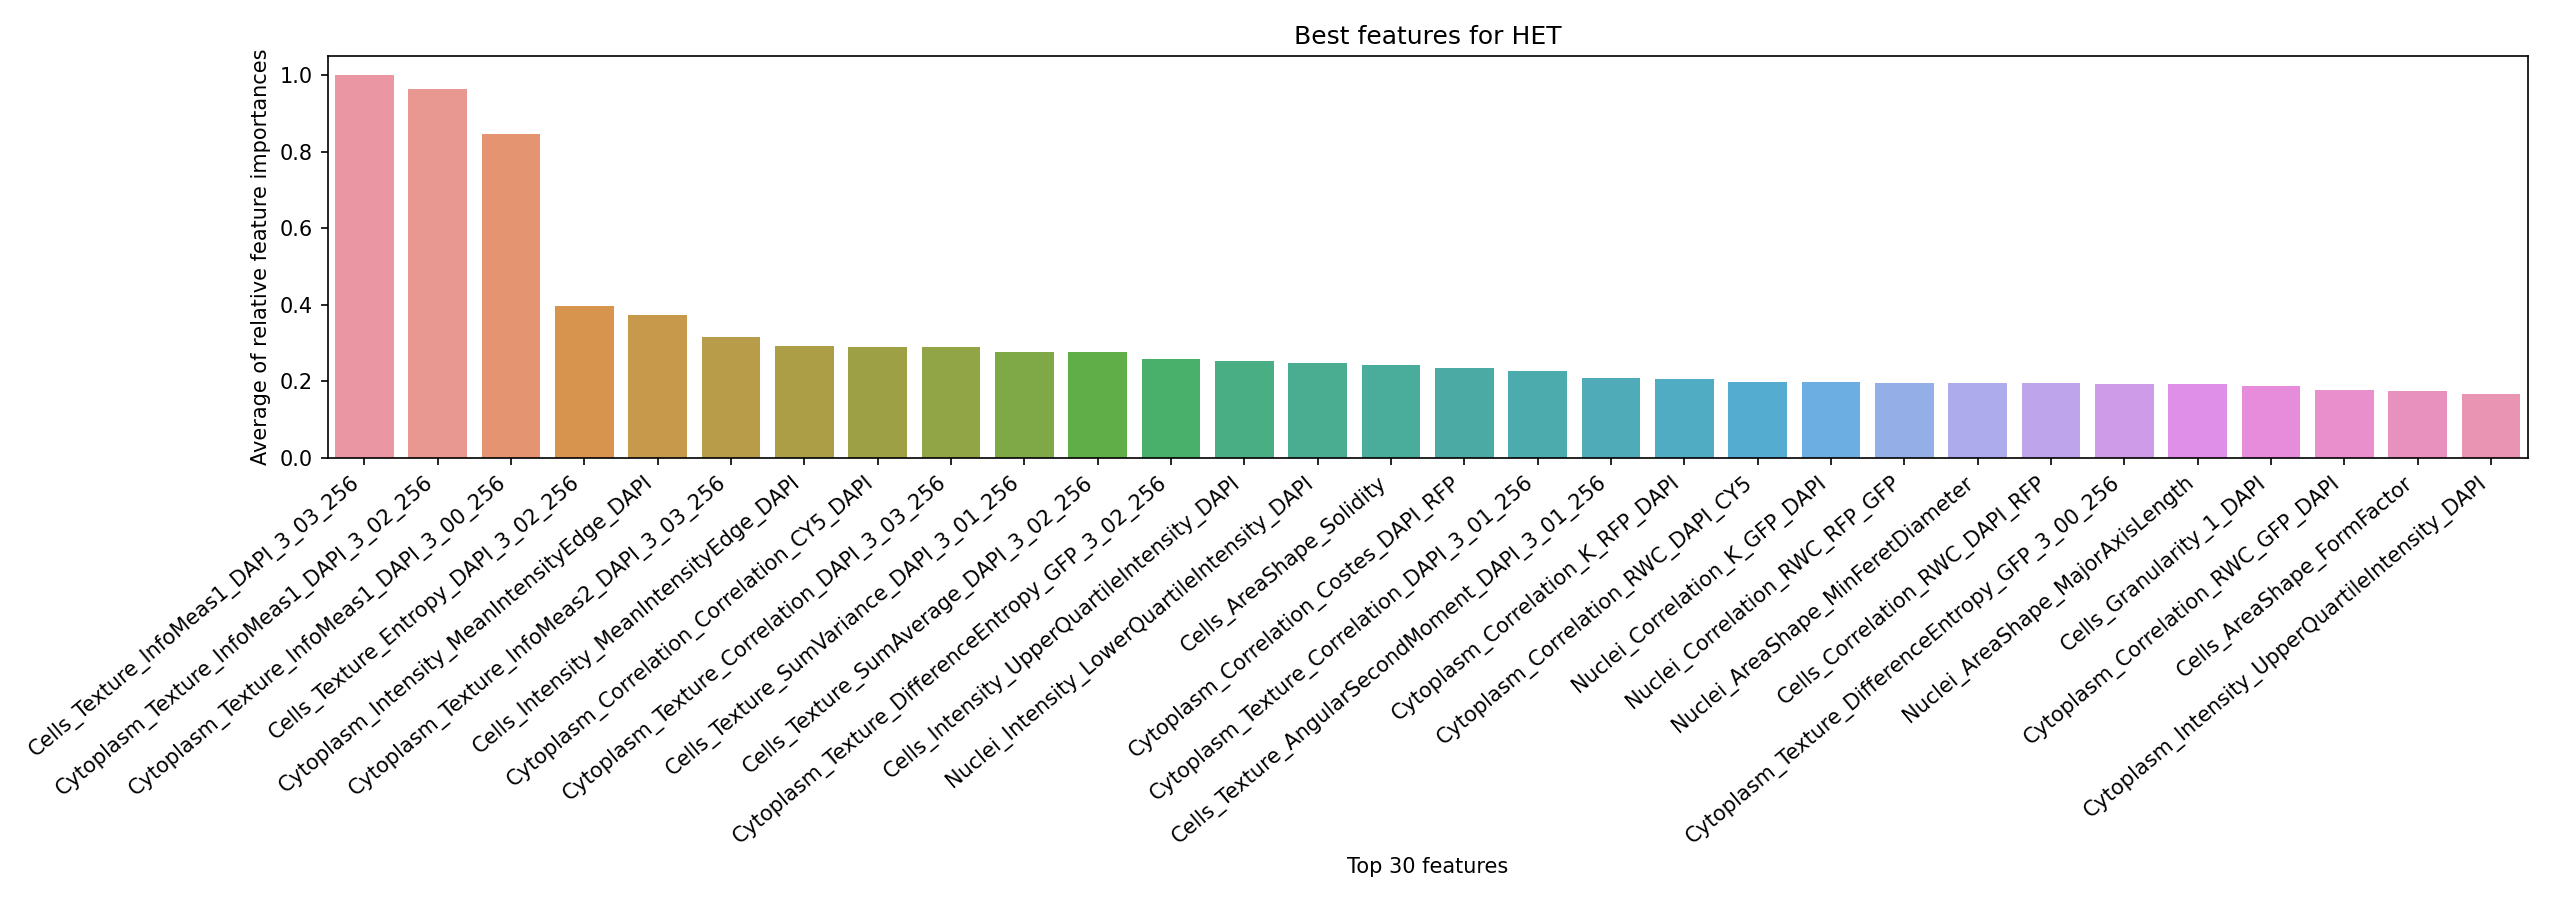

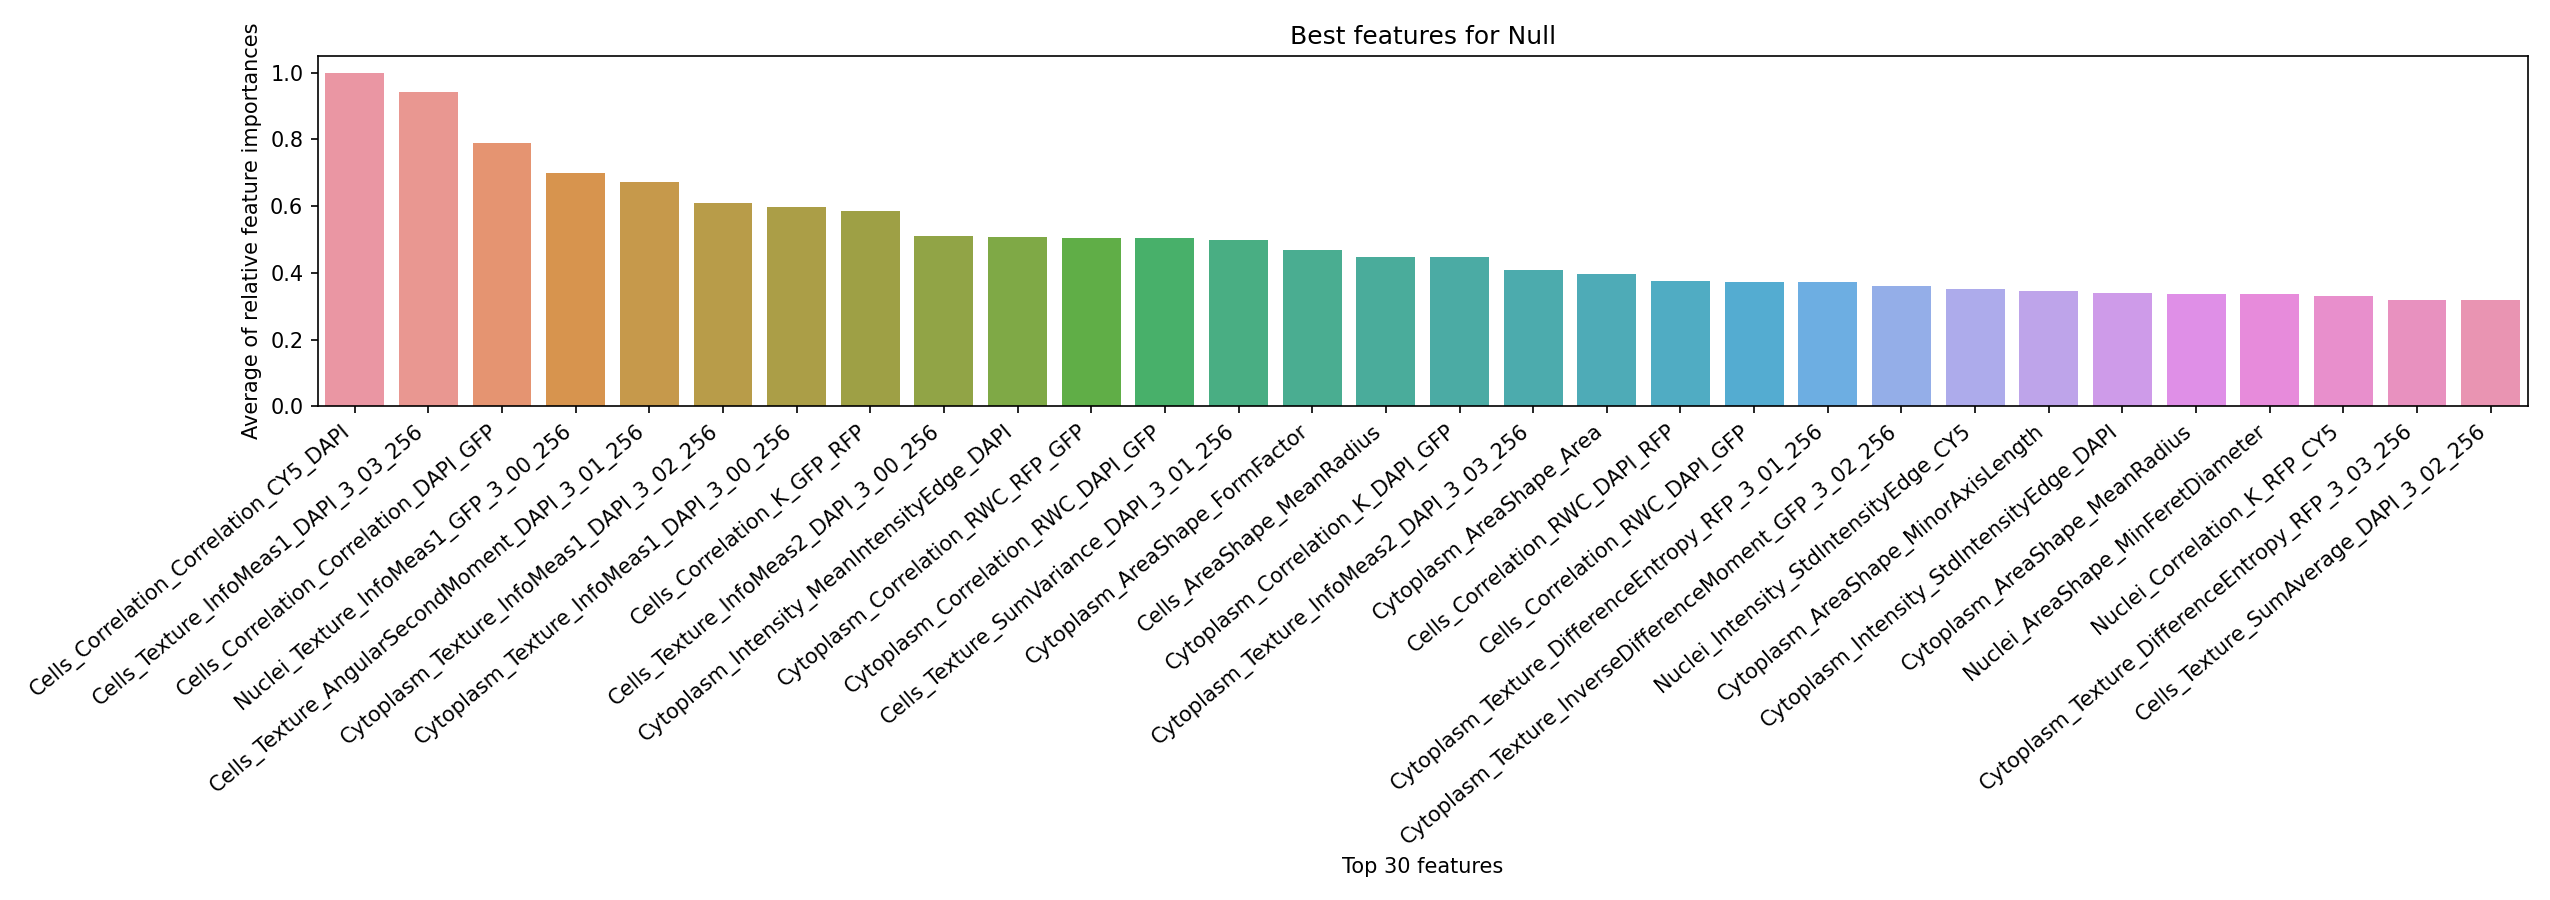

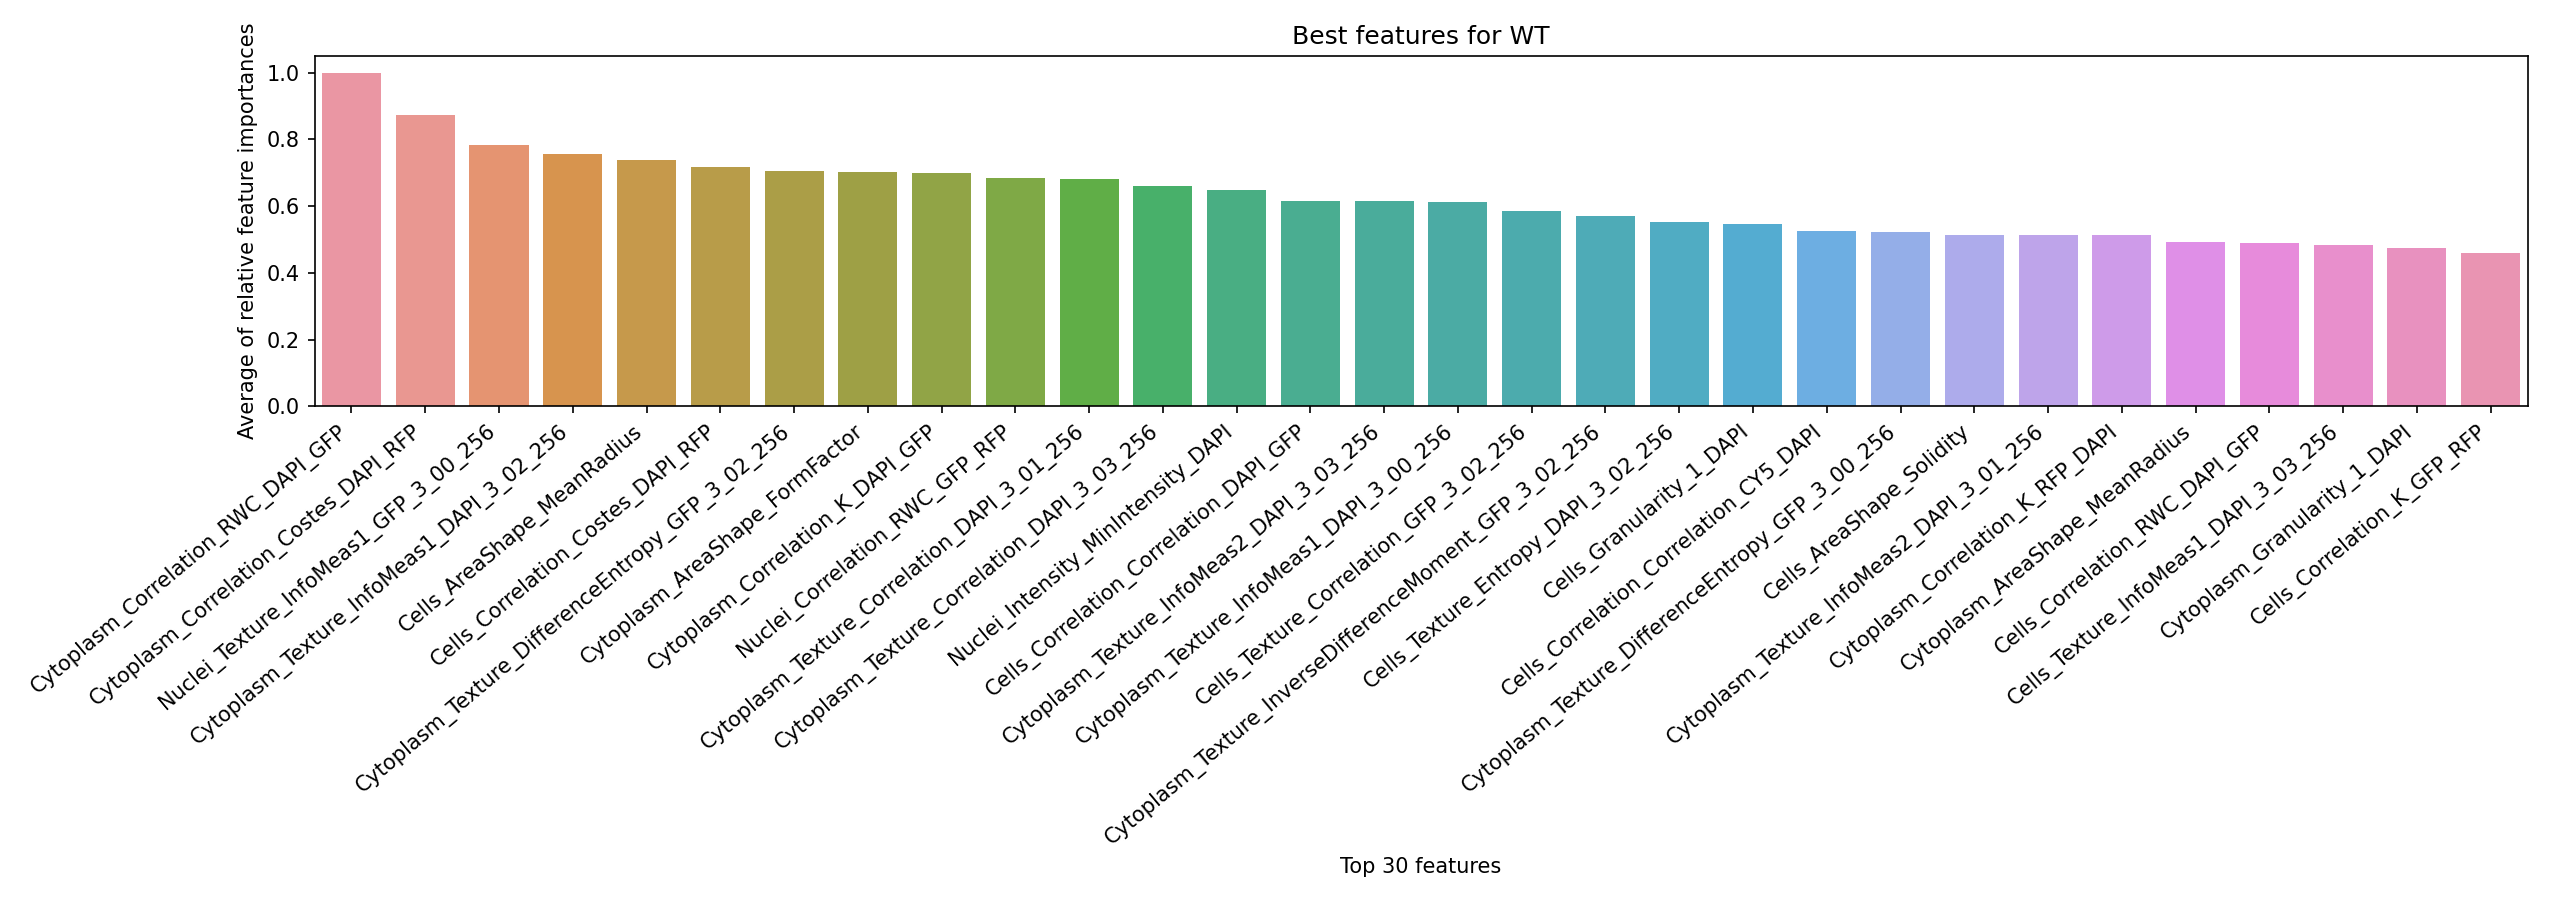

In [5]:
for genotype in featdf[pos_genes]:
    feat_imp = featimp[genotype]["featnorm_avg_norm"][:disp_feat]
    col_names = featimp[genotype]["featnorm_avg_norm"][:disp_feat].index
    plt.figure(figsize=(17, 6))
    ax = sns.barplot(x=np.arange(disp_feat), y=feat_imp)
    ax.set_xticklabels(col_names, rotation=40, ha="right")
    plt.ylabel("Average of relative feature importances")
    plt.xlabel(f"Top {disp_feat} features")
    plt.title(f"Best features for {genotype}")
    plt.tight_layout()
    plt.savefig(f"{out_path}/{genotype}_average_feature_importances.png")

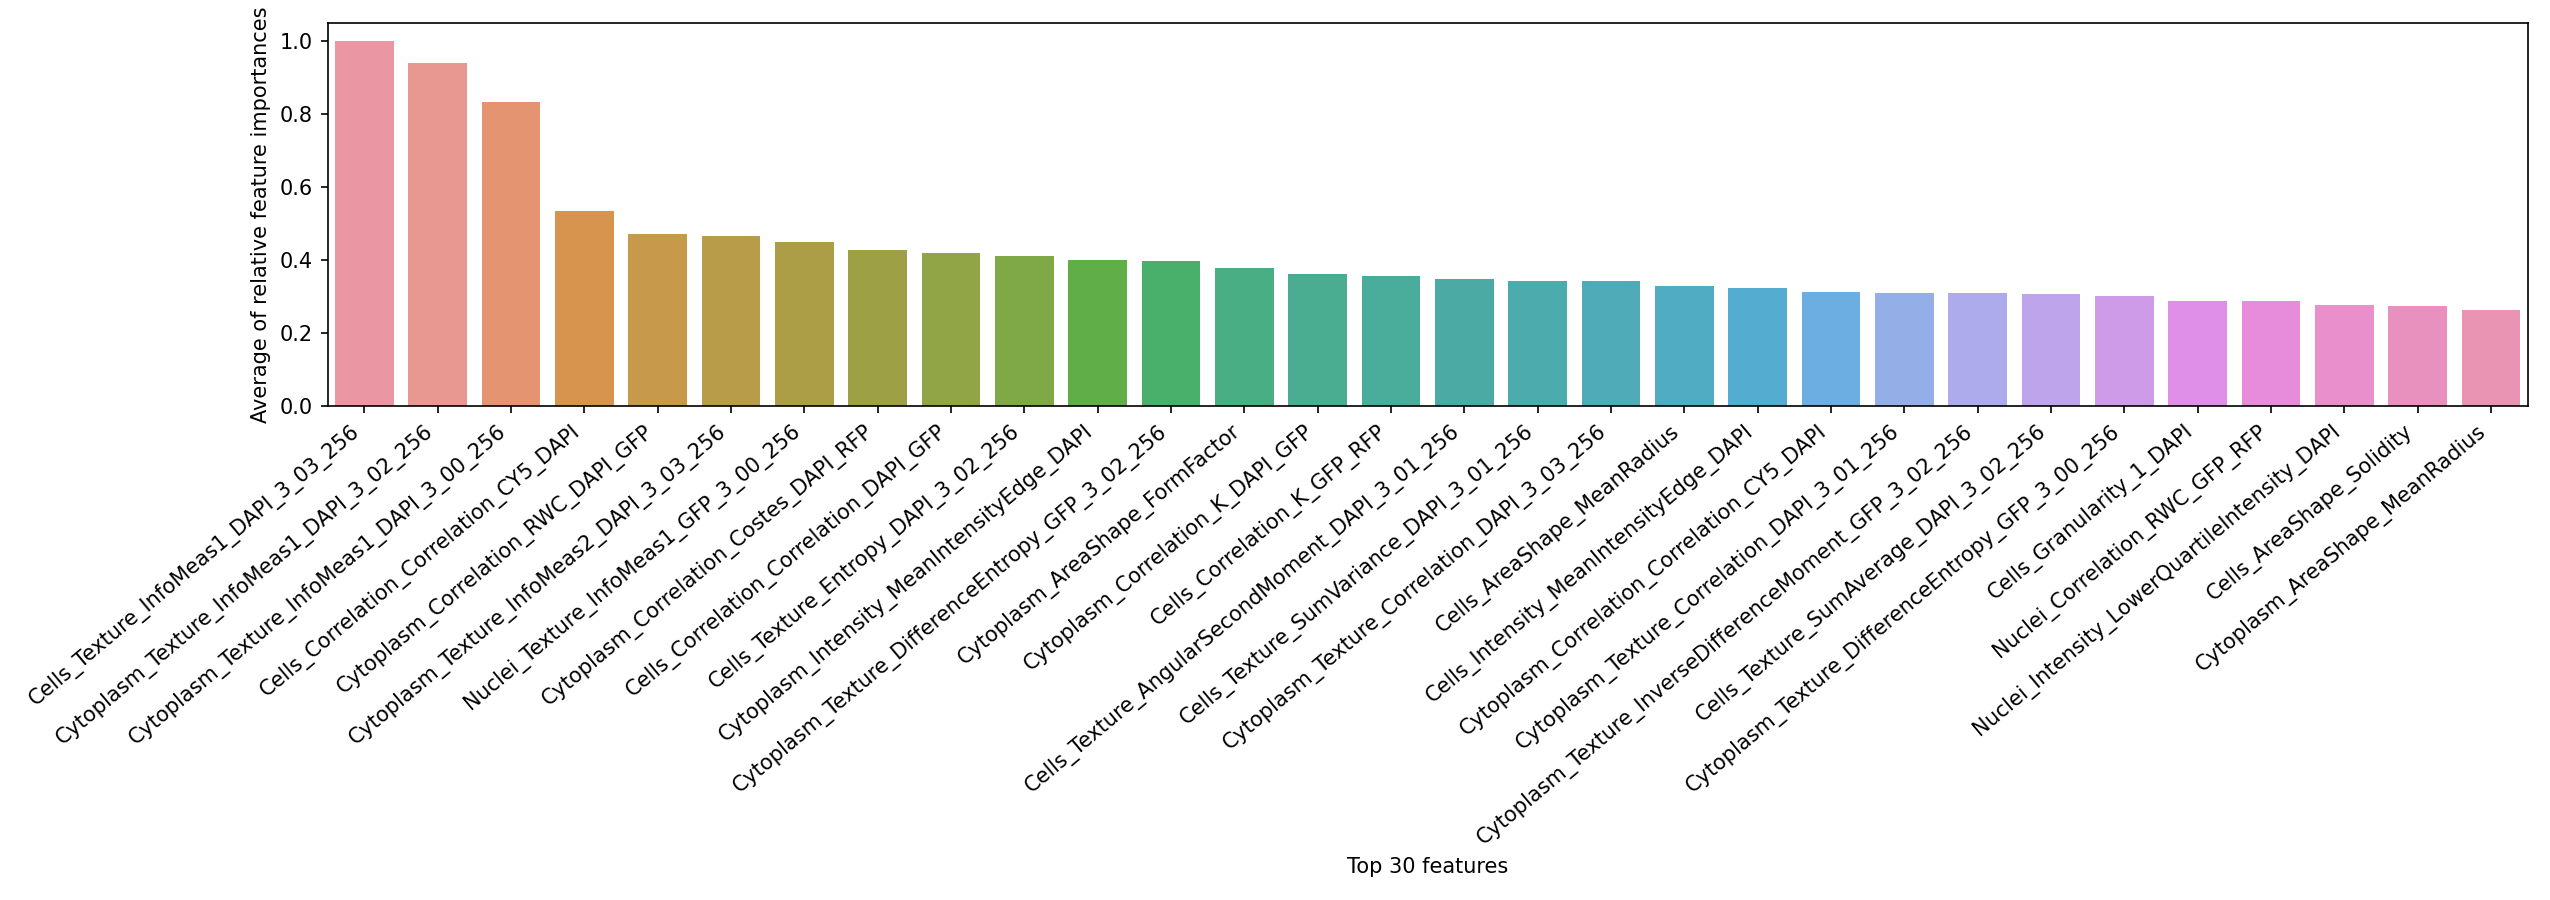

In [6]:
feat_imp = totfeatimp[:disp_feat]
col_names = totfeatimp[:disp_feat].index
plt.figure(figsize=(17, 6))
ax = sns.barplot(x=np.arange(disp_feat), y=feat_imp)
ax.set_xticklabels(col_names, rotation=40, ha="right")
plt.ylabel("Average of relative feature importances")
plt.xlabel("Top n features")
plt.xlabel(f"Top {disp_feat} features")
plt.tight_layout()
plt.savefig(f"{out_path}/overall_average_feature_importances.png")